In [1]:
import numpy as np
from matplotlib import pyplot as plt 
from matplotlib.animation import FuncAnimation
from shapely import LineString
from shapely.plotting import plot_line, plot_polygon
from astropy import table, io
from scipy.stats import ks_2samp
from scipy.optimize import curve_fit
from plot_tools import *

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('figure', dpi=300)
plt.rc('savefig', bbox='tight')

planet_color = color_D
star_color = color_C

In [2]:
# ecosw errors
show = False
if show:
    print('K16', ecosw_err(0.1032, 268.680, 0.0012, 0.038))
    print('K38', ecosw_err(0.2117, 217.6, 0.0051, 1.9))
    print('K1661', ecosw_err(0.112, 36.4, 0.002, 1.1))
    print('K1338', ecosw_err(0.1560, 117.561, 0.0002, 0.073))
    print()

# print percent of 1 star transits
show = False
if show:
    one_star_transit = all_mode0_df['Transit_Value'] == 1
    print(f"{len(all_mode0_df[one_star_transit])/len(all_mode0_df)*100:.2f}%")
    print()

# planet parameter table
write_table = True
if write_table:
    df = observations_df.copy().drop(columns=['outlier'])
    M = np.array(df['M_A']+df['M_B'])
    a_p, a_b = np.array(df['a_p']), np.array(df['a_b'])
    ecosw = np.round(df['ecosw'], 4)
    df = df.drop(columns=['a_b', 'a_p', 'ecosw'])
    df['P_b'] = np.round(a2p(a_b, M), 2)
    df['P_p'] = np.round(a2p(a_p, M), 2)
    df['ecosw'] = ecosw
    tbl = table.Table.from_pandas(df)
    io.ascii.write(tbl, f'{data_dir}/planets.txt', overwrite=True, format='latex')

In [ ]:
# Tides Animation

n_steps = 200
t_age = 2
mu = 0.5
t = np.linspace(0, t_age, n_steps)
e_b, P = solve_circularization((0.5, a2p(0.085, 1), mu, 4.5, 4.), n_steps, t_age)
a_b = p2a(P, 1)

_, ax = plt.subplots(2, 1)
ax[0].plot(t, e_b)
ax[1].plot(t, a_b)
plt.close()

lw = 0.6
xlim, ylim = 0.05, 0.08

x, z = [], []
for _a, _e in zip(a_b, e_b):
    sim = init(M_A=1, M_B=0.8, a_b=_a, a_p=3, 
            inc_b=np.deg2rad(90), inc_p=np.deg2rad(0), 
            Omega_b=np.deg2rad(0), Omega_p=np.deg2rad(0), 
            e_b=_e, omega_b=np.deg2rad(90))
    _x, _, _z = integrate(sim, N=1)
    x.append(_x)
    z.append(_z)

fig, ax = plt.subplots(1, 1, figsize=(4, 4), layout='tight')
 
ax.axis('scaled')
ax.tick_params(axis='both', which='both',     
               bottom=False, top=False,       
               left=False, right=False,
               labelleft=False, labelbottom=False)
ax.set_xlim(-xlim, xlim)
ax.set_ylim(-ylim, ylim)

A_path, = ax.plot([], [], '-', c=color_A, lw=lw)
B_path, = ax.plot([], [], '-', c=color_B, lw=lw)
A_loc, = ax.plot([], [], 'o', c=color_A, markersize=8)
B_loc, = ax.plot([], [], 'o', c=color_B, markersize=8*mu)

def init_ani():
    for o in (A_path, B_path, A_loc, B_loc):
        o.set_data([], [])
    return A_path, B_path, A_loc, B_loc

def update_ani(frame):
    _x, _z = x[frame], z[frame]
    for i, o in enumerate((A_path, B_path)):
        o.set_data(_x[i], _z[i])
    for i, o in enumerate((A_loc, B_loc)):
        o.set_data(_x[i][frame], _z[i][frame])
    return A_path, B_path, A_loc, B_loc

n_frames = n_steps
ani = FuncAnimation(fig, update_ani, frames=n_frames, init_func=init_ani, 
                    blit=True, interval=50)
ani.save('talk/tides.gif', writer='pillow', fps=8)
plt.close()

In [4]:
# Donut

M_A, M_B = 1, 0.9
a_b, a_p = 0.5, 2
inc = 15
e = 0.2
Omega_b = 45
Omega_p = (2, 23, 23)
omega = 80
dinc = (-11, -12, -13)
xlim, ylim = 0.35, 0.18
offset = (225, 211, 209)
N = 1
text = ('No Transits', 'Transits 1 Star', 'Transits Both Stars')
lw = 1

fig = plt.figure(figsize=(6, 9), layout='tight')
gs = fig.add_gridspec(3, hspace=0)
axes = gs.subplots(sharex=True)

for ax, op, di, of, tx in zip(axes, Omega_p, dinc, offset, text):

    sim = init(M_A, M_B, a_b, a_p, np.deg2rad(inc), 
               np.deg2rad(inc+di), np.deg2rad(Omega_b),
               np.deg2rad(op), e, omega_b=np.deg2rad(omega))
    x, y, z = integrate(sim, N=N)

    line_A = LineString(np.transpose((x[0], z[0])))
    plot_line(line_A, ax=ax, add_points=False, linewidth=lw, 
              color=color_A, linestyle='--')
    dilated_A = line_A.buffer(0.015, cap_style=1)
    plot_polygon(dilated_A, ax=ax, add_points=False, alpha=0.3, color=color_A)

    line_B = LineString(np.transpose((x[1], z[1])))
    plot_line(line_B, ax=ax, add_points=False, linewidth=lw, 
              color=color_B, linestyle='--')
    dilated_B = line_B.buffer(0.02*M_B**0.8, cap_style=1)
    plot_polygon(dilated_B, ax=ax, add_points=False, alpha=0.3, color=color_B)

    x_segments = continuous_segments(x[2], y[2]>0)
    z_segments = continuous_segments(z[2], y[2]>0)
    for _x, _z in zip(x_segments, z_segments):
        back = ax.plot(_x, _z, c=planet_color, lw=lw, alpha=0.7, ls='--')
        add_arrow(back[0], position=0.5*xlim)
        
    x_segments = continuous_segments(x[2], y[2]<0)
    z_segments = continuous_segments(z[2], y[2]<0)
    for _x, _z in zip(x_segments, z_segments):
        front = ax.plot(_x, _z, lw=lw+0.5, c=planet_color)
        add_arrow(front[0], position=-0.5*xlim)

    A = (x[0][of], z[0][of])
    A = plt.Circle(A, 0.015, color=color_A, alpha=1)
    ax.add_artist(A)

    B = (x[1][of], z[1][of])
    B = plt.Circle(B, 0.015, color=color_B, alpha=1)
    ax.add_artist(B)

    planet = (x[2][of], z[2][of])
    planet = plt.Circle(planet, 0.01, color=planet_color)
    ax.add_artist(planet)

    ax.axis('scaled')
    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(-ylim, ylim)
    ax.text(xlim-0.01, -ylim+0.01, tx, ha='right', fontsize=28)
    ax.tick_params(axis='both',         
                    which='both',     
                    bottom=False,    
                    top=False,       
                    left=False,
                    right=False,
                    labelleft=False,
                    labelbottom=False)
    
plt.savefig('paper/donut.png')
plt.close()

In [5]:
# Example Animation

lw = 0.6
step = 2

fig, ax = plt.subplots(1, 1, figsize=(4, 4), layout='tight')

sim = init(M_A=1, M_B=0.5, a_b=2, a_p=5, 
           inc_b=np.deg2rad(35), inc_p=np.deg2rad(50), 
           Omega_b=np.deg2rad(50), Omega_p=np.deg2rad(30), 
           e_b=0, omega_b=np.deg2rad(45))
x, y, z = integrate(sim, N=5)

line_A = LineString(np.transpose((x[0], z[0])))
plot_line(line_A, ax=ax, add_points=False, linewidth=lw, 
            color=color_A, linestyle='-')
line_B = LineString(np.transpose((x[1], z[1])))
plot_line(line_B, ax=ax, add_points=False, linewidth=lw, 
            color=color_B, linestyle='-')
ax.plot(x[2], z[2], lw=lw, c='white')
ax.axis('equal')
ax.tick_params(axis='both',         
               which='both',     
               bottom=False,    
               top=False,       
               left=False,
               right=False,
               labelleft=False,
               labelbottom=False)

A, = ax.plot([], [], 'o', c=color_A, markersize=8)
B, = ax.plot([], [], 'o', c=color_B, markersize=8)
P, = ax.plot([], [], 'o', c=planet_color, markersize=4)

def init_ani():
    for o in (A, B, P):
        o.set_data([], [])
    return A, B, P

def update_ani(frame):
    for i, o in enumerate((A, B, P)):
        o.set_data(x[i][step*frame], z[i][step*frame])
    return A, B, P

n_frames = len(x[0])//step
ani = FuncAnimation(fig, update_ani, frames=n_frames, init_func=init_ani, 
                    blit=True, interval=50)
ani.save('talk/circumbinary.gif', writer='pillow', fps=12)
plt.close()

In [6]:
# Bias

M_A, M_B = 1, 0.8
a_b = (1, 0.5)
a_p = 3
inc = 15
e = (0.2, 0)
Omega_b, Omega_p = 50, 30
omega = 80
dinc = -11
xlim, ylim = 0.75, 0.35
offset = (135, 340)
N = 1
text = ('Before Tidal Decay', 'After Tidal Decay')
lw = 0.8

fig = plt.figure(figsize=(6, 4), layout='tight')
gs = fig.add_gridspec(2, hspace=0)
axes = gs.subplots(sharex=True)

for ax, of, tx, a, _e in zip(axes, offset, text, a_b, e):

    sim = init(M_A, M_B, a, a_p, np.deg2rad(inc), 
               np.deg2rad(inc+dinc), np.deg2rad(Omega_b),
               np.deg2rad(Omega_p), _e, omega_b=np.deg2rad(omega))
    x, y, z = integrate(sim, N=N)

    line_A = LineString(np.transpose((x[0], z[0])))
    plot_line(line_A, ax=ax, add_points=False, linewidth=lw, 
              color=color_A, linestyle='-')

    line_B = LineString(np.transpose((x[1], z[1])))
    plot_line(line_B, ax=ax, add_points=False, linewidth=lw, 
              color=color_B, linestyle='-')

    x_segments = continuous_segments(x[2], y[2]>0)
    z_segments = continuous_segments(z[2], y[2]>0)
    for _x, _z in zip(x_segments, z_segments):
        back = ax.plot(_x, _z, c=planet_color, lw=lw, alpha=0.7, ls='--')
        add_arrow(back[0], position=0)
        
    x_segments = continuous_segments(x[2], y[2]<0)
    z_segments = continuous_segments(z[2], y[2]<0)
    for _x, _z in zip(x_segments, z_segments):
        front = ax.plot(_x, _z, lw=lw+0.5, c=planet_color)
        add_arrow(front[0], position=0)

    A = (x[0][of], z[0][of])
    A = plt.Circle(A, 0.025, color=color_A, alpha=1)
    ax.add_artist(A)

    B = (x[1][of], z[1][of])
    B = plt.Circle(B, 0.025, color=color_B, alpha=1)
    ax.add_artist(B)

    planet = (x[2][of], z[2][of])
    planet = plt.Circle(planet, 0.015, color=planet_color)
    ax.add_artist(planet)

    ax.axis('scaled')
    ax.set_xlim(-xlim, xlim)
    ax.set_ylim(-ylim, ylim)
    ax.text(xlim-0.01, -ylim+0.035, tx, ha='right', fontsize=24)
    ax.tick_params(axis='both',         
                    which='both',     
                    bottom=False,    
                    top=False,       
                    left=False,
                    right=False,
                    labelleft=False,
                    labelbottom=False)
    
plt.savefig('paper/bias.png')
plt.close()

In [7]:
# Motivation (Talk)

s, lw, fs, density, a = 15, 1, 24, False, 0.5
pmin, pmax = 0.4, 200
fig_names = ('motiv_ecc', 'motiv_hist')

for i in (0, 1):
    fig, ax = plt.subplots(1, 1, figsize=(7.5, 4.5), layout='tight')
    if not i:
        ax.scatter(windemuth['P(d)'], abs(windemuth['ecosw']), s=s, 
                        edgecolors=color_A, label='Kepler Eclipsing Binaries', 
                        facecolors='none', linewidths=lw)
        ax.scatter(obs_P_b, observations_df['ecosw'], label='Confirmed CBP Hosts', 
                        marker='*', s=150, facecolors=color_C, edgecolors='k', 
                        linewidths=1.2)
        
        ax.set_xlim(pmin, pmax)
        ax.set_xlabel('Binary Period [day]', fontsize=fs)

        ax.set_ylim(0, 1)
        ax.set_ylabel('Binary Eccentricity', fontsize=fs)
        ax.legend(loc=2, fontsize=14)
        ax.grid(True)
    else: 
        nbins = 60
        bins = np.logspace(np.log10(pmin), np.log10(pmax), nbins)
        ax.hist(windemuth['P(d)'], bins=bins, histtype='step', 
                    density=density, color=color_A, 
                    label='Kepler Eclipsing Binaries', lw=lw+0.5)

        for j, p in enumerate(obs_P_b):
            if j: label = '' 
            else: label = 'Confirmed CBP Hosts'
            ax.axvline(p, c='k', ls='--', label=label)
        ax.set_ylabel('Number of Systems', fontsize=fs)
        ax.legend(loc=2, fontsize=14)

        ax.set_xlim(pmin, pmax)
        ax.set_xlabel('Binary Period [day]', fontsize=fs)

        ax.set_ylim(None, 45)

    ax.tick_params(axis='x', pad=10)
    ax.tick_params(axis='both', direction='in',
                   which='major', length=7,
                   top=True, bottom=True, 
                   left=True, right=True, 
                   labelsize=fs-2)
    ax.tick_params(axis='both', direction='in',
                   which='minor', length=4,
                   top=True, bottom=True, 
                   left=True, right=True)
    plt.xscale('log')

    plt.savefig(f'talk/{fig_names[i]}.png')
    plt.close()

In [ ]:
# Motivation (Paper)

s, lw, fs, density, a = 15, 1.25, 24, False, 0.5
pmin, pmax = 0.4, 200

fig = plt.figure(figsize=(7.5, 8), layout='tight')
gs = fig.add_gridspec(2, hspace=0)
axes = gs.subplots(sharex=True)

axes[0].scatter(windemuth['P(d)'], abs(windemuth['ecosw']), s=s, 
                edgecolors='black', label='Kepler\n(Windemuth+ 2019)', 
                facecolors='none', linewidths=lw)
axes[0].scatter(obs_P_b, observations_df['ecosw'], label='Confirmed CBP Hosts', 
                marker='*', s=100, facecolors=star_color, edgecolors='k', 
                linewidths=1)
axes[0].set_ylim(0, 1)
axes[0].set_ylabel('$|e_b\cos(\omega_b)|$', fontsize=fs)
axes[0].legend(loc=2, fontsize=14)

nbins = 60
bins = np.logspace(np.log10(pmin), np.log10(pmax), nbins)
axes[1].hist(windemuth['P(d)'], bins=bins, histtype='step', 
             density=density, color='black', 
             label='Kepler\n(Windemuth+ 2019)', lw=lw+0.5)
for i, p in enumerate(obs_P_b):
    if i: label = '' 
    else: label = 'Confirmed CBP Hosts'
    axes[1].axvline(p, c='k', ls='--', label=label)
axes[1].set_ylabel('Number of Systems', fontsize=fs)
axes[1].legend(loc=2, fontsize=14)

axes[1].set_xlim(pmin, pmax)
axes[1].set_xlabel('$P_{b}$ [day]', fontsize=fs+4)

for ax in axes:
    ax.tick_params(axis='both', direction='in',
                   which='major', length=7,
                   top=True, bottom=True, 
                   left=True, right=True, 
                   labelsize=fs-2)
    ax.tick_params(axis='both', direction='in',
                   which='minor', length=4,
                   top=True, bottom=True, 
                   left=True, right=True)
    ax.tick_params(axis='x', pad=7)
plt.xscale('log')

plt.savefig('paper/motiv.png')
plt.close()

In [9]:
# Binary distribution (Penv)

Penv = (4, 6, 8)
s, lw, fs, density, a = 15, 1.25, 24, False, 0.25
pmin, pmax = 0.2, 200
nmin, nmax = 0, 50

fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(14, 10), sharex=True)
gs = axes[0, 0].get_gridspec()
gs.update(hspace=0, wspace=0)

for axs, penv, label in zip(axes, Penv, hist_titles_penv):

    pop_synth = system_pop(n_pop=10_000,Penv=penv, Pmin=penv*0.75)
    eclipsing_transiting = pop_synth['eclipsing?'] & pop_synth['stable?']
    full_data_ecl = pop_synth[eclipsing_transiting]
    data_ecl = full_data_ecl[:len(windemuth)]

    ecosw = data_ecl['eccentricity']*np.cos(data_ecl['omega'])
    axs[0].scatter(data_ecl['period'], abs(ecosw), s=s, edgecolors='k', 
                   alpha=a, marker='^', label='Initial', 
                   facecolors='none', linewidths=lw)
    ecosw = data_ecl['circ_eccentricity']*np.cos(data_ecl['omega'])
    axs[0].scatter(data_ecl['circ_period'], abs(ecosw), s=s, linewidths=lw, 
                   edgecolors='k', label='Circularized', facecolors='none')
    axs[0].scatter(windemuth['P(d)'], abs(windemuth['ecosw']), s=s, 
                   edgecolors=color_A, label='Kepler\n(Windemuth+ 2019)', 
                   facecolors='none', linewidths=lw, marker='s')
    axs[0].set_ylim(0, 1)

    if penv == Penv[0]: 
        axs[0].legend(loc=2, fontsize=fs-10)
    if penv == Penv[1]:
        axs[0].set_ylabel('$|e_b\cos(\omega_b)|$', fontsize=fs+4, labelpad=10)

    axs[0].tick_params(axis='both', direction='in',
                   which='major', length=7,
                   top=True, bottom=True, 
                   left=True, right=True, 
                   labelsize=fs-2)
    axs[0].tick_params(axis='both', direction='in',
                   which='minor', length=4,
                   top=True, bottom=True, 
                   left=True, right=True)
    axs[0].tick_params(axis='x', pad=7)
    
    axs[0].text(2.8e-1, 0.25, rf'$P_{{\rm env}} = {label[-15:-12]}$ days', 
                fontsize=fs-1, ha='left')
    axs[0].text(2.8e-1, 0.1, rf'$P_{{\rm min}} = {label[-10:-7]}$ days', 
                fontsize=fs-1, ha='left')
    if penv == Penv[0]: axs[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    else: axs[0].set_yticks([0, 0.2, 0.4, 0.6, 0.8])

    nbins = 60
    bins = np.logspace(np.log10(pmin), np.log10(pmax), nbins)
    axs[1].hist(data_ecl['period'], bins=bins, histtype='step', 
                color='k', ls='--', density=density, 
                alpha=a, label='Initial', lw=lw+0.5)
    axs[1].hist(data_ecl['circ_period'], bins=bins, 
                histtype='step', color='k', density=density, 
                label='Circularized', lw=lw+0.5)
    axs[1].hist(windemuth['P(d)'], bins=bins, histtype='step', 
                density=density, color=color_A, 
                label='Kepler\n(Windemuth+ 2019)', lw=lw+0.5)

    if penv == Penv[0]: 
        axs[1].legend(loc=2, fontsize=fs-10)
    if penv == Penv[1]:
        axs[1].set_ylabel('Number of Systems', fontsize=fs+4, 
                          rotation=-90, labelpad=30)
        axs[1].yaxis.set_label_position("right")
    axs[1].set_xlim(pmin, pmax)
    axs[1].set_ylim(nmin, nmax)

    axs[1].tick_params(axis='both', direction='in',
                       which='major', length=7,
                       top=True, bottom=True, 
                       left=True, right=True, 
                       labelleft=False, labelright=True,
                       labelsize=fs-2)
    axs[1].tick_params(axis='both', direction='in',
                       which='minor', length=4,
                       top=True, bottom=True, 
                       labelleft=False, labelright=True,
                       left=True, right=True)
    axs[1].tick_params(axis='x', pad=7)

fig.supxlabel('$P_{b}$ [day]', fontsize=fs+4, y=0.03)
plt.xscale('log')

plt.savefig('paper/binary_dist_penv.png')
plt.close()

In [10]:
# Binary distribution (Talk)

s, lw, fs, density = 15, 1.2, 24, False
pmin, pmax = 0.4, 200
pop_synth = system_pop(n_pop=10_000, Penv=4, Pmin=3)
eclipsing_transiting = pop_synth['eclipsing?'] & pop_synth['stable?']
full_data_ecl = pop_synth[eclipsing_transiting]
data_ecl = full_data_ecl[:len(windemuth)]

fig = plt.figure(figsize=(7.5, 8), layout='tight')
gs = fig.add_gridspec(2, hspace=0)
axes = gs.subplots(sharex=True)

ecosw = data_ecl['eccentricity']*np.cos(data_ecl['omega'])
axes[1].scatter(data_ecl['period'], abs(ecosw), s=s, edgecolors='k', 
                alpha=0.25, marker='^', label='Before Tides', 
                facecolors='none', linewidths=lw)
ecosw = data_ecl['circ_eccentricity']*np.cos(data_ecl['omega'])
axes[1].scatter(data_ecl['circ_period'], abs(ecosw), s=s, linewidths=lw, 
                edgecolors='k', label='After Tides', facecolors='none')
axes[1].scatter(windemuth['P(d)'], abs(windemuth['ecosw']), s=s, 
                edgecolors=color_A, label='Kepler', 
                facecolors='none', linewidths=lw)
axes[1].set_ylim(0, 1)
axes[1].set_ylabel('Binary Eccentricity', fontsize=fs)
axes[1].legend(loc=2, fontsize=14)
axes[1].grid(True)

nbins = 60
bins = np.logspace(np.log10(pmin), np.log10(pmax), nbins)
axes[0].hist(data_ecl['period'], bins=bins, histtype='step', 
             color='k', ls='--', density=density, 
             alpha=0.5, label='Before Tides', lw=lw+0.5)
axes[0].hist(data_ecl['circ_period'], bins=bins, 
             histtype='step', color='k', density=density, 
             label='After Tides', lw=lw+0.5)
axes[0].hist(windemuth['P(d)'], bins=bins, histtype='step', 
             density=density, color=color_A, 
             label='Kepler', lw=lw+0.5)
axes[0].set_ylabel('Number of Systems', fontsize=fs)
axes[0].legend(loc=2, fontsize=14)

axes[0].set_xlim(pmin, pmax)
axes[1].set_xlabel('Binary Period [day]', fontsize=fs+4)

for ax in axes:
    ax.tick_params(axis='x', pad=10)
    ax.tick_params(axis='both', direction='in',
                   which='major', length=7,
                   top=True, bottom=True, 
                   left=True, right=True, 
                   labelsize=fs-2)
    ax.tick_params(axis='both', direction='in',
                   which='minor', length=4,
                   top=True, bottom=True, 
                   left=True, right=True)
plt.xscale('log')

plt.savefig('talk/binary_dist.png')
plt.close()

In [11]:
# Results (Paper)

files = files_control
hist_titles = hist_titles_control
fractional = True

fs = 28

dfs = [extract_eclipsing_transiting(df) 
       for df in [read_df(file) for file in files]]

nbinsx = 60
nbinsy = 45
pbmin = ppmin = 200
pbmax = ppmax = 0
for df in dfs:
     p, b = df.Planet_Period, df.Binary_Period
     pbmin = min(np.amin(b), pbmin)
     pbmax = max(np.amax(b), pbmax)
     ppmin = min(np.amin(p), ppmin)
     ppmax = max(np.amax(p), ppmax)
bins = (np.logspace(np.log10(ppmin), np.log10(ppmax), nbinsx), 
        np.logspace(np.log10(pbmin), np.log10(pbmax), nbinsy))
vmax = 0
for df in dfs:
     hist = np.histogram2d(df.Planet_Period, df.Binary_Period, bins=bins)
     if fractional: tmp = 100*hist[0].max() / len(df)
     else: tmp = hist[0].max()
     vmax = max(vmax, tmp)
norm = plt.cm.colors.Normalize(vmin=0, vmax=vmax)
cmap = 'bone_r'
cmap = plt.cm.get_cmap(cmap)
sc = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure(figsize=(7, 18)) #21
gs = fig.add_gridspec(len(files), hspace=0)
axes = gs.subplots(sharex=True, sharey=True)

x = np.linspace(pbmin, pbmax, 100)
for i, (df, ax) in enumerate(zip(dfs, axes)):
     if fractional:
          weights = np.full_like(df.Planet_Period.values, 100/len(df), dtype=float)
     else:
          weights = np.ones_like(df.Planet_Period.values, dtype=float)
     hist, _, _, _ = ax.hist2d(df.Planet_Period, df.Binary_Period, 
                               bins=bins, cmap=cmap, norm=norm, weights=weights)
     ax.scatter(obs_P_p, obs_P_b, label='Confirmed CBPs', marker='*', s=100, 
                facecolors=star_color, edgecolors='k', linewidths=1)
     ax.plot(2**1.5*x, x, 'k--', label=r'$P_p=2^{3/2}P_b$', lw=2)

     ax.set_xscale('log')
     ax.set_yscale('log')
     ax.set_ylim(pbmin, 200)
     ax.tick_params(axis='both', direction='in', top=True, bottom=True, 
                    right=True, left=True, labelsize=fs-6, which='major', 
                    length=7)
     ax.tick_params(axis='both', direction='in', top=True, bottom=True, 
                    right=True, left=True, labelsize=fs-6, which='minor',
                    length=4)

     if fractional:
          h = 10e-1 if i == 0 else 18e-1
          ax.text(5e4, h, f'{len(df)} Systems', fontsize=fs+2, ha='right')
     ax.text(5e4, 4.5e-1, hist_titles[i], fontsize=fs, ha='right')

     if i == 0: ax.legend(fontsize=16, loc='upper left')
     if i == 1: 
          ax.set_ylabel('$P_{b}$ [day]', fontsize=fs+4)
     if i == 2: 
          ax.set_xlabel('$P_{p}$ [day]', fontsize=fs+4)
          ax.tick_params(axis='x', pad=7)

cbar = fig.colorbar(sc, ax=axes, aspect=30, orientation='horizontal', 
                    location='top', pad=0)
cbar.set_label(label='Percent of Detected Systems', fontsize=fs, labelpad=10)
cbar.ax.tick_params(axis='x', labelsize=fs-8, bottom=False, top=True, 
                    labeltop=True, labelbottom=False)

plt.savefig('paper/2dhist_control.png')
plt.close()

In [12]:
# Results (Penv)

files = files_penv
hist_titles = hist_titles_penv
fractional = True

fs = 28

dfs = [extract_eclipsing_transiting(df) for df in [read_df(file) for file in files]]

nbinsx = 60
nbinsy = 45
pbmin = ppmin = 200
pbmax = ppmax = 0
for df in dfs:
     p, b = df.Planet_Period, df.Binary_Period
     pbmin = min(np.amin(b), pbmin)
     pbmax = max(np.amax(b), pbmax)
     ppmin = min(np.amin(p), ppmin)
     ppmax = max(np.amax(p), ppmax)
bins = (np.logspace(np.log10(ppmin), np.log10(ppmax), nbinsx), 
        np.logspace(np.log10(pbmin), np.log10(pbmax), nbinsy))
vmax = 0
for df in dfs:
     hist = np.histogram2d(df.Planet_Period, df.Binary_Period, bins=bins)
     if fractional: tmp = 100*hist[0].max() / len(df)
     else: tmp = hist[0].max()
     vmax = max(vmax, tmp)
norm = plt.cm.colors.Normalize(vmin=0, vmax=vmax)
cmap = 'bone_r'
cmap = plt.cm.get_cmap(cmap)
sc = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure(figsize=(7, 18))
gs = fig.add_gridspec(len(files), hspace=0)
axes = gs.subplots(sharex=True, sharey=True)

x = np.linspace(pbmin, pbmax, 100)
for i, (df, ax) in enumerate(zip(dfs, axes)):
     if fractional:
          weights = np.full_like(df.Planet_Period.values, 100/len(df), dtype=float)
     else:
          weights = np.ones_like(df.Planet_Period.values, dtype=float)
     hist, _, _, _ = ax.hist2d(df.Planet_Period, df.Binary_Period, 
                               bins=bins, cmap=cmap, norm=norm, weights=weights)
     ax.scatter(obs_P_p, obs_P_b, label='Confirmed CBPs', marker='*', s=100, 
                facecolors=star_color, edgecolors='k', linewidths=1)
     ax.plot(2**1.5*x, x, 'k--', label=r'$P_p=2^{3/2}P_b$', lw=2)

     ax.set_xscale('log')
     ax.set_yscale('log')
     ax.set_ylim(pbmin, 200)
     ax.tick_params(axis='both', direction='in', top=True, bottom=True, 
                    right=True, left=True, labelsize=fs-6, which='major', 
                    length=7)
     ax.tick_params(axis='both', direction='in', top=True, bottom=True, 
                    right=True, left=True, labelsize=fs-6, which='minor',
                    length=4)

     if fractional:
          h = 20e-1
          ax.text(4e4, h, f'{len(df)} Systems', fontsize=fs+2, ha='right')
     ax.text(4e4, 11e-1, hist_titles[i], fontsize=fs, ha='right')

     if i == 0: ax.legend(fontsize=16, loc='upper left')
     if i == 1: 
          ax.set_ylabel('$P_{b}$ [day]', fontsize=fs+4)
     if i == 2: 
          ax.set_xlabel('$P_{p}$ [day]', fontsize=fs+4)
          ax.tick_params(axis='x', pad=7)

cbar = fig.colorbar(sc, ax=axes, aspect=30, orientation='horizontal', 
                    location='top', pad=0)
cbar.set_label(label='Percent of Detected Systems', fontsize=fs, labelpad=10)
cbar.ax.tick_params(axis='x', labelsize=fs-8, bottom=False, top=True, 
                    labeltop=True, labelbottom=False)

plt.savefig('paper/2dhist_penv.png')
plt.close()

In [13]:
# Results (Talk)

files = files_control[::2]
hist_titles = hist_titles_control[::2]
fractional = True

fs = 28

dfs = [extract_eclipsing_transiting(df) for df in [read_df(file) for file in files]]

nbinsx = 60
nbinsy = 45
pbmin = ppmin = 200
pbmax = ppmax = 0
for df in dfs:
     p, b = df.Planet_Period, df.Binary_Period
     pbmin = min(np.amin(b), pbmin)
     pbmax = max(np.amax(b), pbmax)
     ppmin = min(np.amin(p), ppmin)
     ppmax = max(np.amax(p), ppmax)
bins = (np.logspace(np.log10(ppmin), np.log10(ppmax), nbinsx), 
        np.logspace(np.log10(pbmin), np.log10(pbmax), nbinsy))
vmax = 0
for df in dfs:
     hist = np.histogram2d(df.Planet_Period, df.Binary_Period, bins=bins)
     if fractional: tmp = 100*hist[0].max() / len(df)
     else: tmp = hist[0].max()
     vmax = max(vmax, tmp)
norm = plt.cm.colors.Normalize(vmin=0, vmax=vmax)
cmap = 'bone_r'
cmap = plt.cm.get_cmap(cmap)
sc = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fig = plt.figure(figsize=(7, 12))
gs = fig.add_gridspec(len(files), hspace=0)
axes = gs.subplots(sharex=True, sharey=True)

x = np.linspace(pbmin, pbmax, 100)
for i, (df, ax) in enumerate(zip(dfs, axes)):
     if fractional:
          weights = np.full_like(df.Planet_Period.values, 100/len(df), dtype=float)
     else:
          weights = np.ones_like(df.Planet_Period.values, dtype=float)
     hist, _, _, _ = ax.hist2d(df.Planet_Period, df.Binary_Period, 
                               bins=bins, cmap=cmap, norm=norm, weights=weights)
     ax.scatter(obs_P_p, obs_P_b, label='Confirmed CB Systems', marker='*', s=100, 
                facecolors=color_C, edgecolors='k', linewidths=1)
     ax.plot(2**1.5*x, x, 'k--', label='Stability Limit', lw=2)

     ax.set_xscale('log')
     ax.set_yscale('log')
     ax.set_ylim(0.3, 200)
     ax.tick_params(axis='both', direction='in', top=True, bottom=True, 
                    right=True, left=True, labelsize=fs-6, which='major', 
                    length=7)
     ax.tick_params(axis='both', direction='in', top=True, bottom=True, 
                    right=True, left=True, labelsize=fs-6, which='minor',
                    length=4)

     if fractional:
          h = 10e-1 if i == 0 else 18e-1
          ax.text(2e4, h, f'{len(df)} Systems', fontsize=fs+2, ha='right')
     ax.text(2e4, 4.5e-1, hist_titles[i], fontsize=fs, ha='right')

     if i == 0: ax.legend(fontsize=16, loc='upper left')
     if i == 1: ax.tick_params(axis='x', pad=10)

fig.supxlabel('Planet Period [day]', fontsize=fs+4, y=0.04)
fig.supylabel('Binary Period [day]', fontsize=fs+4, x=-0.01)

cbar = fig.colorbar(sc, ax=axes, aspect=30, orientation='horizontal', 
                    location='top', pad=0)
cbar.set_label(label='Percent of Detected Systems', fontsize=fs, labelpad=10)
cbar.ax.tick_params(axis='x', labelsize=fs-8, bottom=False, top=True, 
                    labeltop=True, labelbottom=False)

plt.savefig('talk/2dhist_control.png')
plt.close()

In [14]:
# Results: Parameter Sweep

fs = 32
nrows = 3*4
ncols = 3
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(17, 19),
                        sharex=True, sharey=True)
gs = axs[0, 0].get_gridspec()
gs.update(hspace=0, wspace=0)
dfs_flat = [extract_eclipsing_transiting(df) for dfs in all_dfs for df in dfs]

nbinsx = 60
nbinsy = 45
pbmin = ppmin = 200
pbmax = ppmax = 0

for df in dfs_flat:
    p, b = df.Planet_Period, df.Binary_Period
    pbmin = min(np.amin(b), pbmin)
    pbmax = max(np.amax(b), pbmax)
    ppmin = min(np.amin(p), ppmin)
    ppmax = max(np.amax(p), ppmax)
bins = (np.logspace(np.log10(ppmin), np.log10(ppmax), nbinsx), 
        np.logspace(np.log10(pbmin), np.log10(pbmax), nbinsy))

vmax = 0
for df in dfs_flat:
    hist = np.histogram2d(df.Planet_Period, df.Binary_Period, bins=bins)
    tmp = 100*hist[0].max() / len(df)
    vmax = max(vmax, tmp)
norm = plt.cm.colors.Normalize(vmin=0, vmax=vmax)
cmap = plt.cm.get_cmap('bone_r')
sc = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
x = np.linspace(pbmin, pbmax, 100)

for ncol in range(ncols):
    start = 0
    step = 3 if ncol == 2 else 4
    j = ncol
    for nrow in range(nrows):
        end = start+step
        slc, col = slice(start, end), ncol
        if start % step: 
            start += 1
            continue
        for _ax in axs[slc, col]: _ax.remove()
        ax = fig.add_subplot(gs[slc, col])
        i = nrow // step
        df = extract_eclipsing_transiting(all_dfs[j][i])
        ax.tick_params(axis='both', direction='in', top=True, bottom=True, 
                       right=True, left=True, labelsize=fs-8, which='major', 
                       length=7, labelleft=(j==0), labelright=(j==2), pad=7)
        ax.tick_params(axis='both', direction='in', top=True, bottom=True, 
                       right=True, left=True, which='minor', length=4)
        weights = np.full_like(df.Planet_Period.values, 100/len(df), dtype=float)
        hist, _, _, _ = ax.hist2d(df.Planet_Period, df.Binary_Period, 
                                  bins=bins, cmap=cmap, 
                                  norm=norm, weights=weights)
        ax.scatter(obs_P_p, obs_P_b, label='Confirmed CBPs', marker='*', 
                   s=100, facecolors=star_color, edgecolors='k', linewidths=0.7)
        ax.plot(2.8*x, x, 'k--', lw=2, label=r'$P_p=2^{3/2}P_b$')
        ax.set_xscale('log')
        ax.set_yscale('log')
        h = 15e-1 if j == 2 else 13e-1
        txt = f'{len(df)} Systems'
        ax.text(2e4, h, txt, fontsize=fs-6, ha='right')
        ax.text(2e4, 7e-1, all_hist_titles[j][i], fontsize=fs-6, ha='right')
        if not i and not j:
            ax.legend(fontsize=14, loc='upper left')
        start += 1
fig.supylabel('$P_{b}$ [day]', fontsize=fs, x=0.065)
fig.supxlabel('$P_{p}$ [day]', fontsize=fs, y=0.065)
cbar = fig.colorbar(sc, ax=fig.axes, aspect=75, 
                    orientation='horizontal', 
                    location='top', pad=0)
cbar.set_label(label='Percent of Detected Systems', fontsize=fs, labelpad=15)
cbar.ax.tick_params(axis='x', labelsize=fs-8, 
                    bottom=False, top=True, length=7,
                    labeltop=True, labelbottom=False)

plt.savefig('paper/2dhist_params.png')
plt.close()

In [15]:
# Transit checker validation

fs = 24
df = extract_eclipsing_transiting(all_mode0_df)

norm = plt.cm.colors.Normalize(vmin=0)
cmap = plt.cm.get_cmap('bone_r')
sc = plt.cm.ScalarMappable(norm=norm, cmap=cmap)

fig, ax = plt.subplots(1, 1, layout='constrained', figsize=(6, 5))

x = df.Planet_Semimajor_Axis/df.Binary_Semimajor_Axis
plot = np.ones_like(x, dtype=bool)
y = abs(df.Planet_Sky_Inclination - df.Binary_Inclination)
y = np.rad2deg([i for i in y.values])
y = df.Planet_Sky_Inclination
y = np.rad2deg(np.array([abs(np.pi/2-i) for i in y.values]))

bins = (np.logspace(np.log10(x.min()), np.log10(x.max()), 60), 100)
hist, _, _, _ = ax.hist2d(x[plot], y[plot], bins=bins, cmap=cmap, norm=norm)

x_min = x.min()
ax.tick_params(labelsize=fs)
x = np.linspace(x_min, x.max(), 1_000)
ax.plot(x, np.rad2deg(1/x), 'k--')
ax.text(30, 2.5, r'$i_p = a_b/a_p$', 
        ha='left', fontsize=fs-4)
ax.set_xscale('log')
ax.set_xlabel('$a_p/a_b$', fontsize=fs, labelpad=-7)
ax.set_ylim(0, 15)
ax.set_ylabel('$i_p$ [$^\circ$]', fontsize=fs)
ax.tick_params(axis='both', direction='in', 
               top=True, bottom=True, 
               left=True, right=True, 
               labelsize=fs-2, which='major',
               length=7, pad=6)
ax.tick_params(axis='both', direction='in', 
               top=True, bottom=True, 
               left=True, right=True, 
               labelsize=fs-2, which='minor',
               length=4)

cbar = fig.colorbar(sc, ax=ax, aspect=30, pad=-0.03)
cbar.set_label(label='Number of Transiting Systems', fontsize=fs)
cbar.ax.tick_params(axis='y', labelsize=fs-4)

plt.savefig('paper/transit_check.png')
plt.close()

In [20]:
# Minimum Period (Penv)

fs = 28
n_samps = np.arange(10, 21)
offset = 0.13
N = 10_000
locs3 = np.arange(-offset, 1.5*offset, offset)
locs4 = np.arange(-1.5*offset, 2*offset, offset)
colors = (color_A, color_D, color_B, color_C)

files = files_penv
labels = hist_titles_penv
offsets = locs3

fig, ax = plt.subplots(1, 1, layout='constrained', figsize=(9, 6))
for file, label, offset, color in zip(files, labels, offsets, colors):
    df = read_df(file)
    df = extract_eclipsing_transiting(df)

    R = df.Radius_A + df.Radius_B
    a = df.Binary_Semimajor_Axis
    e = df.Binary_Eccentricity
    p = df.Binary_Period
    ecosw = e*np.cos(np.deg2rad([i for i in df.Binary_omega.values]))
    corr = (1-np.abs(ecosw))/(1-e**2)
    eclipsing = abs(df.Binary_Inclination-np.pi/2) <= R/a * corr
    df = df[eclipsing]
    periods = df.Binary_Period
    idxs = df.index
    def compute_min_period(_):
        rng = np.random.default_rng(_)
        idx = rng.choice(idxs, n, replace=False)
        return np.min(periods[idx])
    min_period_dist = []
    for n in n_samps:
        if N > 100:
            with Pool() as pool:
                min_period = pool.map(compute_min_period, range(N))
        else:
            min_period = list(map(compute_min_period, range(N)))
        min_period_dist.append(np.percentile(min_period, (5, 50, 95)))

    low, mid, hi = np.array(min_period_dist).T
    yerr = (mid-low, hi-mid)
    ax.errorbar(n_samps+offset, mid, yerr=yerr, fmt='o', capsize=3, 
                markersize=5, lw=2, label=label, c=color, capthick=2)
ax.tick_params(axis='both', direction='in', 
               top=True, bottom=True, 
               left=True, right=True, 
               labelsize=fs, which='both', 
               length=7)
ax.set_ylim(0, 15)
ax.axhline(min(obs_P_b), c='k', ls='--', label='Observed\nMinimum $P_b$')
ax.legend(fontsize=16, loc=1)

ax.set_xlabel(r'Number of Observed Planets $N_{\rm obs}$', fontsize=fs)
ax.set_ylabel(r'Minimum $P_b$ [day]', fontsize=fs)

plt.savefig('paper/minp_penv.png')
plt.close()

In [ ]:
# 

test = True

def report(label, p):
    txt = f" - {label} p = {p:.2e}"
    if p > 0.05: txt += ' [SIGNIFICANT]'
    print(txt)

if test:
    print('Statistics for P_b distributions:')
    for file, label in zip(files_control, hist_titles_control):
        df = read_df(file)
        df = extract_eclipsing_transiting(df)
        result = ks_2samp(df.Binary_Period.values, np.unique(obs_P_b))

        label = label.replace('\n', ' ') + ':'
        report(f"{label:<26}", result.pvalue)

if not test:
    for file, label in zip(files_penv, hist_titles_penv):
        if test: break
        df = read_df(file)
        df = extract_eclipsing_transiting(df)
        result = ks_2samp(df.Binary_Period.values, obs_P_b)

        label = label.replace('$', '').replace(r'{\rm ', '').replace('}', '')
        report(label, result.pvalue)

if not test:
    print('Statistics for P_p distributions:')
    for file, label in zip(files_control, hist_titles_control):
        df = read_df(file)
        df = extract_eclipsing_transiting(df)
        result = ks_2samp(df.Planet_Period.values, obs_P_p)

        label = label.replace('\n', ' ') + ':'
        report(f"{label:<26}", result.pvalue)

if not test:
    for file, label in zip(files_penv, hist_titles_penv):
        if test: break
        df = read_df(file)
        df = extract_eclipsing_transiting(df)
        result = ks_2samp(df.Planet_Period.values, obs_P_p)

        label = label.replace('$', '').replace(r'{\rm ', '').replace('}', '')
        report(label, result.pvalue)

if not test:
    print('Statistics for P_p/P_b distributions:')
    for file, label in zip(files_control, hist_titles_control):
        if test: break
        df = read_df(file)
        df = extract_eclipsing_transiting(df)
        x = df.Planet_Period.values/df.Binary_Period.values
        y = np.array(obs_P_p)/np.array(obs_P_b)
        result = ks_2samp(x, y)

        label = label.replace('\n', ' ') + ':'
        report(f"{label:<26}", result.pvalue)

if not test:
    for file, label in zip(files_penv, hist_titles_penv):
        if test: break
        df = read_df(file)
        df = extract_eclipsing_transiting(df)
        x = df.Planet_Period.values/df.Binary_Period.values
        y = np.array(obs_P_p)/np.array(obs_P_b)
        result = ks_2samp(x, y)

        label = label.replace('$', '').replace(r'{\rm ', '').replace('}', '')
        report(label, result.pvalue)

if not test:
    print('Statistics for P_b/P_HW distributions:')
    for file, label in zip(files_control, hist_titles_control):
        df = read_df(file)
        df = extract_eclipsing_transiting(df)

        P_HW = []
        for _, row in df.iterrows():
            mu = row.Mass_B/(row.Mass_A+row.Mass_B)
            a_HW = HW99(mu, row.Binary_Eccentricity, row.Binary_Semimajor_Axis)
            P_HW.append(a2p(a_HW, row.Mass_A+row.Mass_B))
        x = df.Binary_Period.values/np.array(P_HW)

        P_HW = []
        for _, planet in all_systems.iterrows():
            mu = planet['M_B']/(planet['M_B']+planet['M_B'])
            a_HW = HW99(mu, planet['e_b'], planet['a_b'])
            P_HW.append(a2p(a_HW, planet['M_A']+planet['M_B']))
        y = np.array(obs_P_b)/np.array(P_HW)

        result = ks_2samp(x, y)

        label = label.replace('\n', ' ') + ':'
        report(f"{label:<26}", result.pvalue)

Statistics for P_b distributions:
 - Control Case:              p = 5.55e-04
 - Planets Form After Decay:  p = 8.16e-06
 - Planets Form Before Decay: p = 1.85e-01 [SIGNIFICANT]


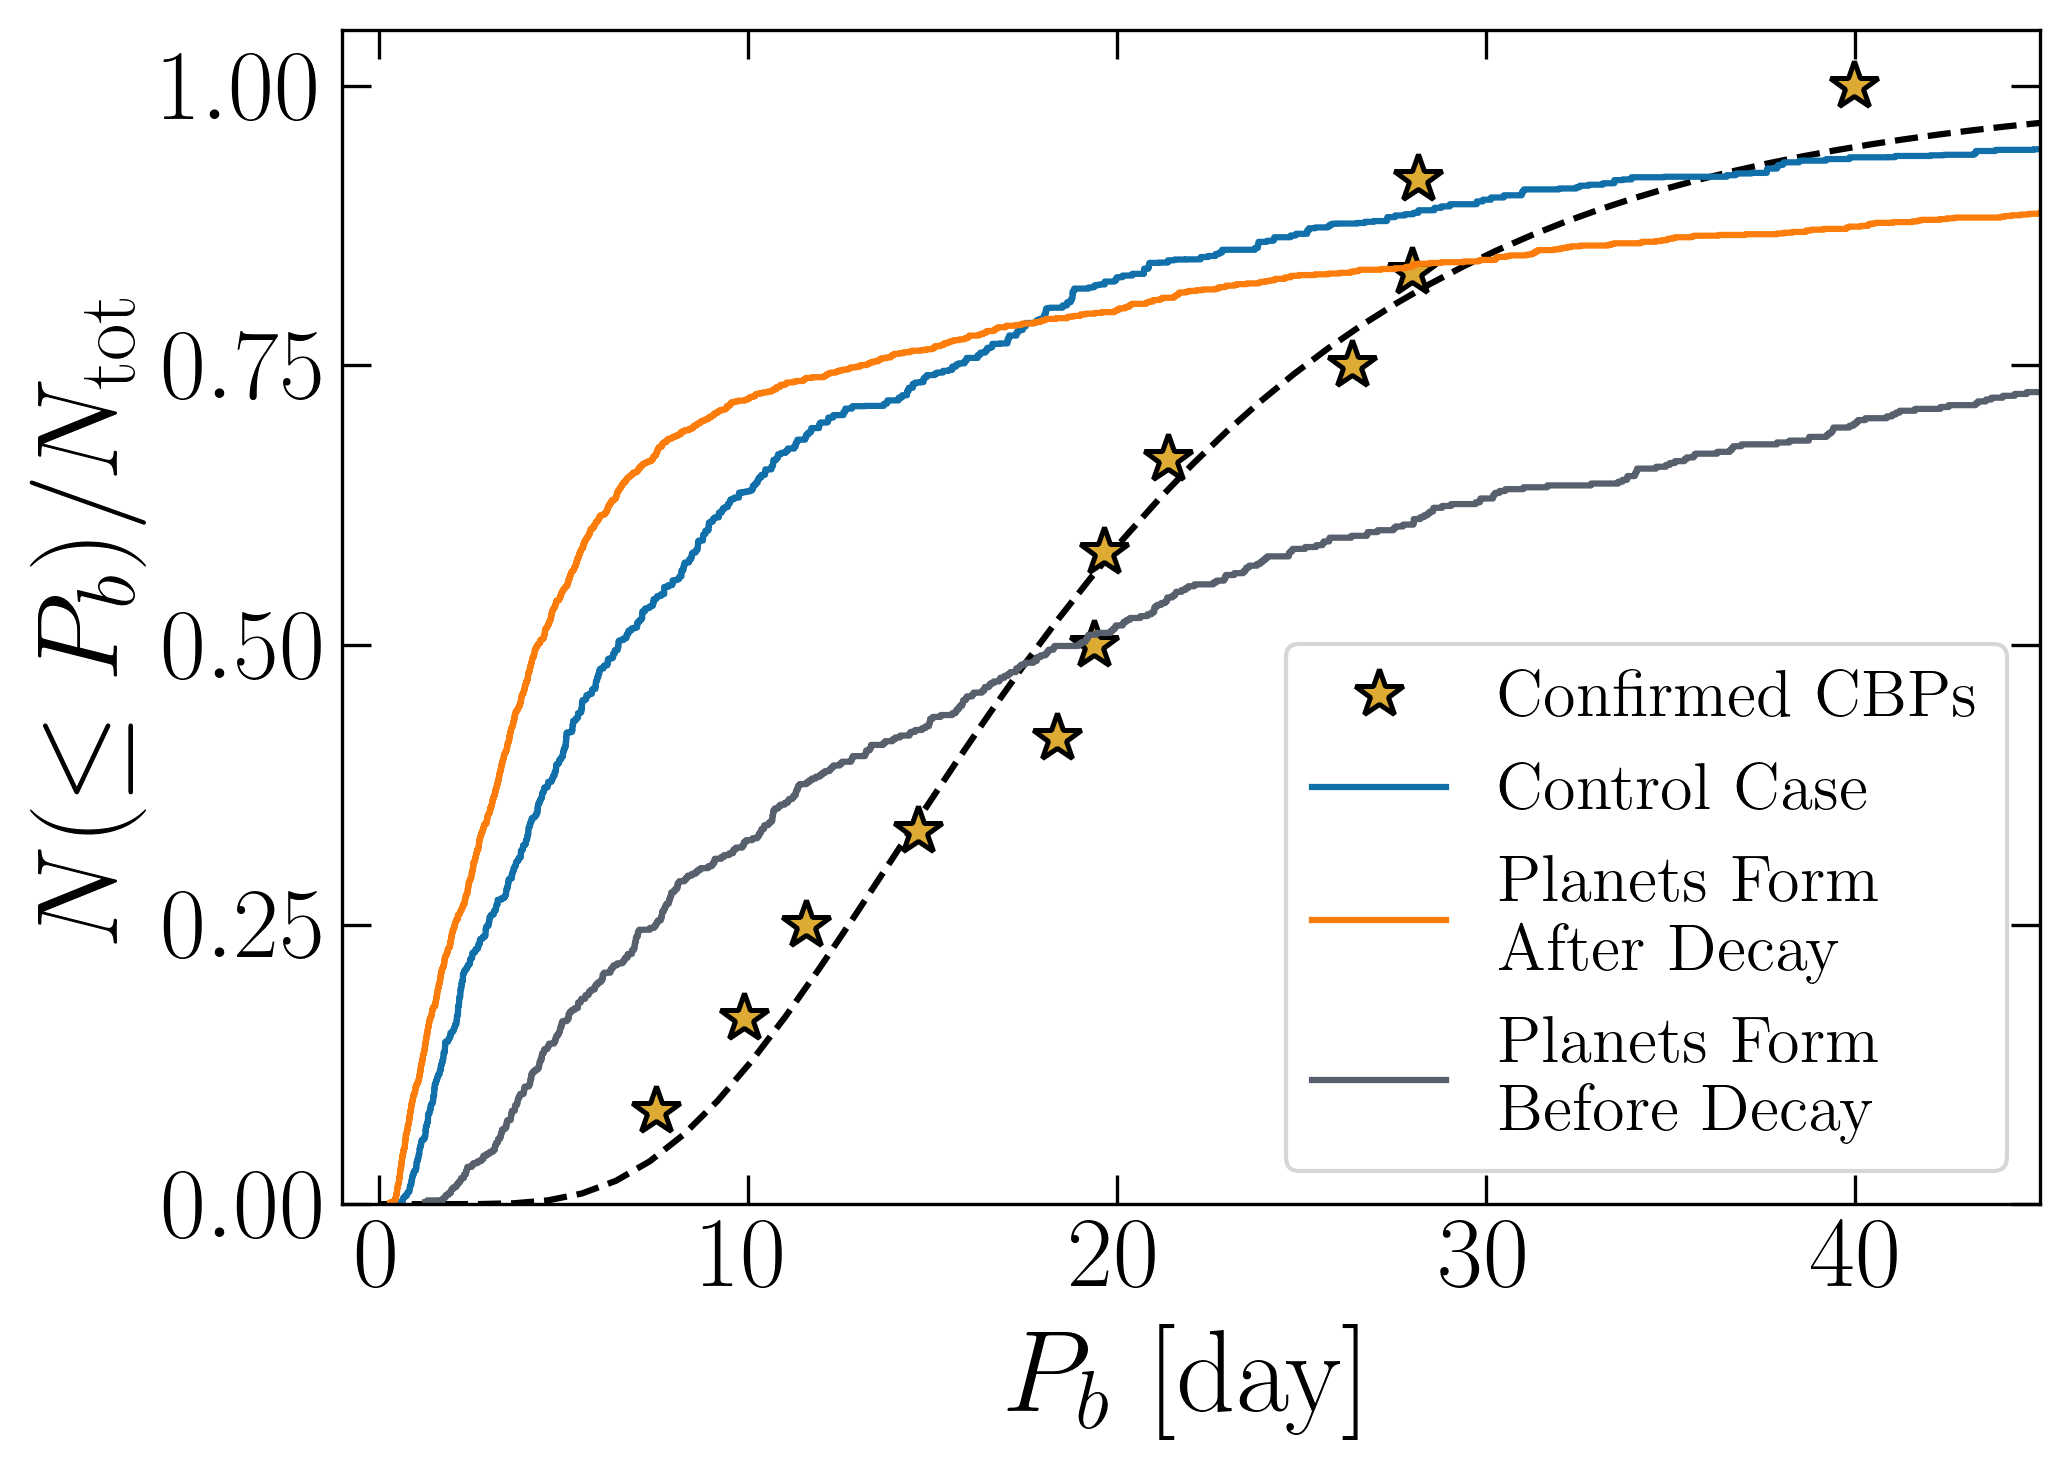

In [19]:
# Binary Period CDF

fs = 28
fit = True
x_max = 45
fig = plt.figure(figsize=(7, 5), layout='tight')
_x = np.linspace(0, x_max)
model, median = lognormal_cdf, lognormal_median

x, y = get_cdf(np.unique(obs_P_b))
if fit:
    popt, pcov = curve_fit(model, x, y)
    plt.plot(_x, model(_x, *popt), 'k--', linewidth=1.5)
    # print(f'{"Data:":<26} median = {median(*popt):.3f} days (sigma = {popt[1]:.3f})')
plt.plot(x, y, label='Confirmed CBPs', marker='*', ms=12, lw=1.5, c='k',
         ls='none' if fit else '--', mfc=star_color, mec='k', mew=1.2)

colors = (color_A, color_B, color_D)
for file, label, c in zip(files_control, hist_titles_control, colors):
    df = extract_eclipsing_transiting(read_df(file))

    x, y = get_cdf(df.Binary_Period.values)
    plt.step(x, y, where='post', label=label, lw=1.5, c=c)
    if fit:
        popt, pcov = curve_fit(model, x, y)
        # plt.plot(_x, model(_x, *popt), '--', c=c, linewidth=1.5)
        label = label.replace("\n", " ") + ":"
        # print(f'{label:<26} median = {median(*popt):.3f} days (sigma = {popt[1]:.3f})')

plt.gca().tick_params(axis='both', direction='in', 
                      top=True, bottom=True, 
                      left=True, right=True, 
                      labelsize=fs-4, which='both', 
                      length=7)

plt.xlim(-1, x_max)
plt.ylim(0, 1.05)
plt.xlabel(r'$P_b$ [day]', fontsize=fs)
plt.ylabel(r'$N(\le P_b) / N_{\rm tot}$', fontsize=fs)
plt.legend(fontsize=fs-12)
plt.show()
# plt.savefig('paper/pb_cdf.png')
# plt.close()